# Assigment 2: CAMSHIFT
## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

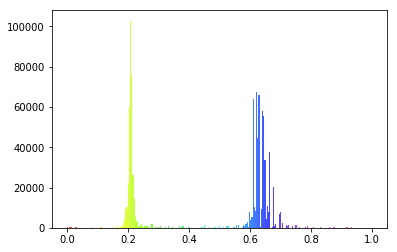

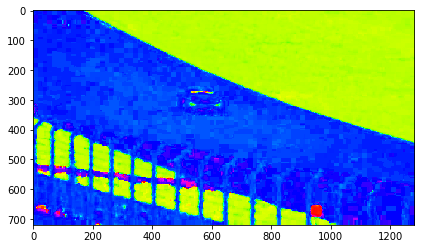

In [2]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')
import math
IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20

image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

# ...

def createColorHistogram(img, binCount = 256, out = plt):
    roi = color.rgb2hsv(img)
    invalid = 0 #ToDo
    #initialize list for plotting
    pixel = []   
    #search and count pixel hues
    for x in range(roi.shape[0]):
        for y in range(roi.shape[1]):
            hue = roi[x][y][0]
            pixel.append(hue)
            
    #fig, axs = out.subplots()
    n, bins, patches = out.hist(pixel, binCount,  facecolor='g', alpha=0.75) 
    
    bar_colors = []

    
    # prepare color list for the bucket colors
    for i in range(binCount):
        current_bin_color_hsv = np.array([[[i/float(binCount), 1, 1]]], dtype=np.float) # hsv ist between 0 and 1
        bar_color_rgb = color.hsv2rgb(current_bin_color_hsv)
        bar_color_rgb_norm = (bar_color_rgb[0][0][0],bar_color_rgb[0][0][1], bar_color_rgb[0][0][2])
        bar_colors.append(bar_color_rgb_norm)        
    
    # set bucket colors
    for thispatch, i in zip(patches, range(binCount)):
        thispatch.set_facecolor(bar_colors[i])
    return n, bins, patches
    
    
createColorHistogram(image)
plt.show()

img_hsv = color.rgb2hsv(image)
img_hsv[:, :, 1] = 1
img_hsv[:, :, 2] = 1
img_rgb = color.hsv2rgb(img_hsv)
io.imshow(img_rgb)


* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


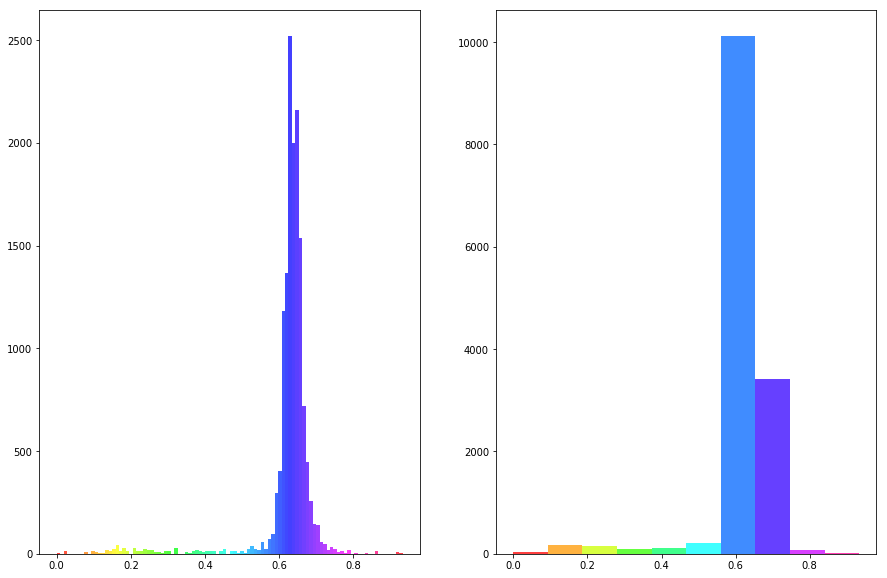

In [3]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
    
histCar100 = createColorHistogram(imageCar, 100, ax1)

histCar10 = createColorHistogram(imageCar, 10, ax2)

plt.savefig('testbilder/car_100 and_10_bins.png')



## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

InvalidPixel: 719888
ValidPixel: 201712
 0.7811284722222223


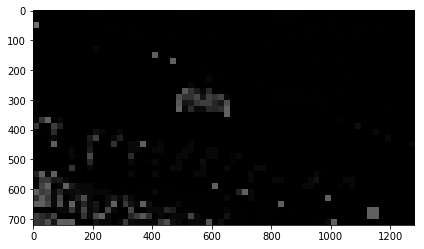

In [4]:
def calculateProbFor(pixel_hsv, nHist, nbins, minSaturation, minValue):
    if (pixel_hsv[1] < minSaturation) or (pixel_hsv[2] < minValue):
        return -1
    
    mass_of_histogramm = np.sum(nHist)
    current_hue = pixel_hsv[0]
    current_bin = math.floor(current_hue*nbins)
    number_of_counts = nHist[current_bin]
    relative_frequency = number_of_counts/mass_of_histogramm
    return relative_frequency

'''MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2'''
#Low and high thresholds are
#set off 10% of the maximum pixel value

# Tipp: in der Nacht sind alle Katzen grau ;)
def createProbDistribution(image, objectHist, nbins, minSaturation, minValue, searchBlock):
    probBlockSizeX, probBlockSizeY = searchBlock
    pixelPerProbBlock = probBlockSizeX*probBlockSizeY
    
    probDistribution = np.empty_like(image)
    
    #ToDo: initialize probDistribution with color
    for x in range(probDistribution.shape[0]):
        for y in range(probDistribution.shape[1]):
            probDistribution[x][y] = np.array([200,0 ,255])
               
    countBlocksX = math.floor(probDistribution.shape[0]/probBlockSizeX)
    countBlocksY = math.floor(probDistribution.shape[1]/probBlockSizeY)
    image_hsv = color.rgb2hsv(image)
    n, bins, patches = objectHist
    invalidPixel=0
    validPixel=0
    
    for currentBlockX in range(countBlocksX):
            x = currentBlockX * probBlockSizeX
            for currentBlockY in range(countBlocksY): 
                y = currentBlockY * probBlockSizeY
                
                #iterate over area
                probPerArea = 0
                currentPixelPerBlock = pixelPerProbBlock
                for a in range(probBlockSizeX):
                    for b in range(probBlockSizeY):
                        current_pixel = image_hsv[x+a][y+b]
                        probability = calculateProbFor(current_pixel, n, nbins, minSaturation, minValue)
                        if (probability < 0):
                            currentPixelPerBlock-=1
                            invalidPixel+=1
                        else:
                            probPerArea += probability
                            validPixel+=1
                
                try:
                    probPerArea = probPerArea/currentPixelPerBlock
                    probInGrey = np.array([probPerArea,probPerArea,probPerArea])*255
                except ZeroDivisionError: # if all pixels are invalid set the probability to zero (black)
                    probInGrey = np.array([0,0,0]) 
                
                #color area with probability
                for a in range(probBlockSizeX):
                    for b in range(probBlockSizeY):
                        probDistribution[x+a][y+b] = probInGrey

    print("InvalidPixel:", invalidPixel)
    print("ValidPixel:",validPixel)
    print("", invalidPixel/(validPixel+invalidPixel))
    
    return probDistribution
            
#lastFrame = io.imread('images/racecar/151.jpeg')
lastFrame = io.imread('images/racecar.png')
#lastFrame = imageCar

#lastFrame = io.imread('images/taco/001.jpg')
#face = lastFrame[160:280, 320:450]

nbins = 25 #20 to 80
#histogramFace = createColorHistogram(face, nbins, ax1)
histogramCar = createColorHistogram(imageCar, nbins, ax1)
searchBlock = (20, 20)

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5

probDistr = createProbDistribution(lastFrame, histogramCar, nbins, MIN_SATURATION_CAR, MIN_VALUE_CAR, searchBlock)
#probDistr = createProbDistribution(lastFrame, histogramFace, nbins, MIN_SATURATION_TACO, MIN_VALUE_TACO, searchBlock)

io.imshow(probDistr)


### ROI auf Bild anzeigen


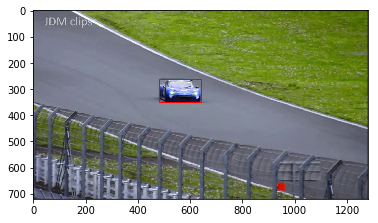

In [5]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

drawROI(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

In [ ]:
from scipy import ndimage

#io.imshow(image[260:350, 480:640])
#oberer Rand, unterer Rand, linkerRand, rechter Rand

def meanShift(probImage, initialLeftCorner, initialWidth, initialHeight, out = plt):
    initX, initY = initialLeftCorner
    relativeCenter = (initialWidth/2, initialHeight/2)
    searchWindow = probImage[initY:initY+initialHeight, 
                             initX: initX+initialWidth]
    lastLeftCorner = initialLeftCorner
    threshold = 4
    shiftAmount = threshold + 10
    drawROI(probImage, lastLeftCorner[0], lastLeftCorner[1], initialWidth, initialHeight)

    while shiftAmount > threshold:
        x,y,z = ndimage.measurements.center_of_mass(searchWindow)
        newRelativeCenter = (y, x) # https://github.com/scipy/scipy/issues/3040
        newShift = [new - old for new, old in zip(newRelativeCenter, relativeCenter)]
        newLeftCorner = [int(round(old_corner+ shift)) for old_corner, shift in zip(lastLeftCorner, newShift)]

        shiftAmount = math.sqrt(newShift[0]**2 + newShift[1]**2)
        searchWindow = probImage[newLeftCorner[1]:
                                 newLeftCorner[1]+initialHeight,
                                 newLeftCorner[0]: 
                                 newLeftCorner[0]+initialWidth]
        lastLeftCorner = newLeftCorner
    return (lastLeftCorner[0], lastLeftCorner[1])

        


nbins = 25 #20 to 80
histogramCar = createColorHistogram(imageCar, nbins)
searchBlock = (10, 10)

#probDistr = createProbDistribution(lastFrame, histogramFace, nbins, MIN_SATURATION_TACO, MIN_VALUE_TACO, searchBlock)

leftCorners = []

for i in range(10):
    lastFrame = io.imread('images/racecar/00{0}.jpeg'.format(str(i)))
    #'{0}, {1}, {2}'.format('a', 'b', 'c')
    probDistr = createProbDistribution(lastFrame, histogramCar, nbins, MIN_SATURATION_CAR, MIN_VALUE_CAR, searchBlock)
    leftCorners.append(meanShift(probDistr, (240, 130), 80, 45))

#leftCornersCentered
for x,y in leftCorners:
    drawROI(lastFrame, x, y, 80, 45)

InvalidPixel: 169904
ValidPixel: 60496
 0.7374305555555556
InvalidPixel: 180909
ValidPixel: 49491
 0.7851953125
InvalidPixel: 179684
ValidPixel: 50716
 0.7798784722222222


##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)